In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataframe
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv', delimiter=',')
df.head(1)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection


Describe the Data

In [3]:
df.describe(include=[np.object])


,DBA,BORO,BUILDING,STREET,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
count,399559,399918,399809,399909,399913,399918,399918,398783,393414,392939,399918,195413,192820,399918,398783
unique,20936,6,7256,3328,25165,84,1414,5,97,93,3,6,1325,1,34
top,DUNKIN' DONUTS,MANHATTAN,0,BROADWAY,7186566210,American,01/01/1900,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Critical,A,08/24/2016,08/28/2017,Cycle Inspection / Initial Inspection
freq,4296,159574,2372,14791,240,90968,1135,380632,55785,55785,220082,154194,455,399918,230431


Plotted the grades divided by boros

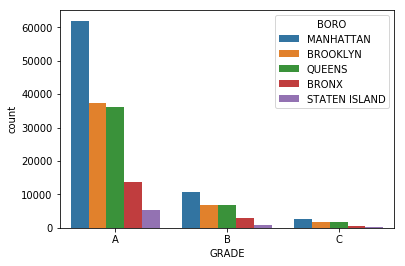

In [4]:
grades = df[df['GRADE'].isin(['A','B', 'C'])]
#grades['GRADE'].value_counts()
ax = sns.countplot(x='GRADE', hue='BORO', data=grades, order=grades['GRADE'].value_counts().index, hue_order=grades['BORO'].value_counts().index)

Plotted the average scores by boro

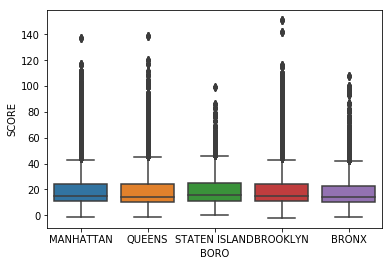

In [5]:
df['SCORE'].dropna()
boros = df[df['BORO'] != 'Missing']
ax = sns.boxplot(x='BORO', y='SCORE', data=boros)


Look at the violations by season

Change the date fromat
Some dates are recorded wrongly, the inspections start on Jan 1, 2010.
All dates with a date earlier than Jan 1, 2010 have been dropped since there is no date that could be used to replace it.

In [6]:
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'])
df[df['INSPECTION DATE'] > '2009-12-31']
df['MONTH']=pd.DatetimeIndex(df['INSPECTION DATE']).month
season_dict = {}
for month in range(1,13):
    if month > 2 and month < 6:
        season_dict[month] = 'Spring'
    elif month > 2 and month < 9:
        season_dict[month] = 'Summer'
    elif month > 2 and month < 12:
        season_dict[month] = 'Fall'
    else:
        season_dict[month] = 'Winter'

df['SEASON'] = df['MONTH'].map(season_dict)

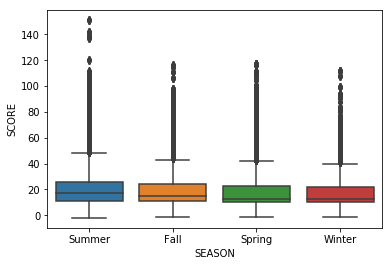

In [7]:
ax = sns.boxplot(x='SEASON', y='SCORE', data=df )

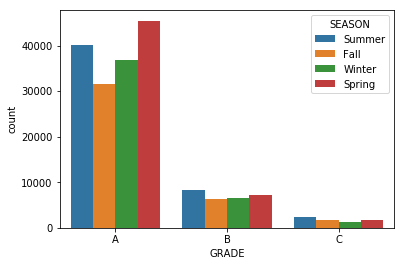

In [8]:
grades_by_seas = df[df['GRADE'].isin(['A','B', 'C'])]
ax = sns.countplot(x='GRADE', hue='SEASON', data=grades_by_seas, order=grades_by_seas['GRADE'].value_counts().index)

Most common violations by boro

In [17]:
# Open the violation grouping file
file_in = 'Violations_explanation.csv'
viol_dict = {}
with open(file_in, 'r') as f_in:
    f_in.readline() # Skip the header
    for line in f_in.readlines():
        line = line.strip('\n')
        line = line.split(';')
        viol_dict[line[0]] = line[-1]
df['VIOLATION TYPE'] = df['VIOLATION CODE'].map(viol_dict)
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,MONTH,SEASON,VIOLATION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-06-15,Violations were cited in the following area(s).,...,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection,6,Summer,Food Temperature
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2014-11-25,Violations were cited in the following area(s).,...,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection,11,Fall,Documentation
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,2016-10-03,Violations were cited in the following area(s).,...,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection,10,Fall,Facility Amenities
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,2017-05-17,Violations were cited in the following area(s).,...,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection,5,Spring,Food Temperature
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,2017-03-30,Violations were cited in the following area(s).,...,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection,3,Spring,Animals


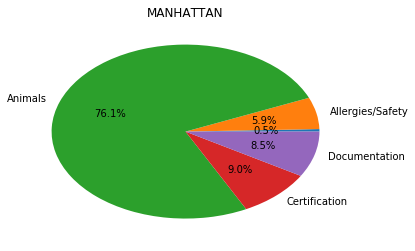

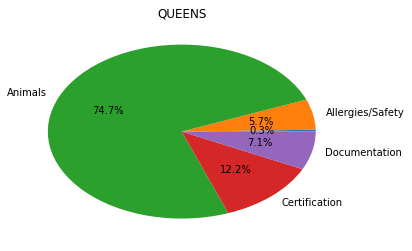

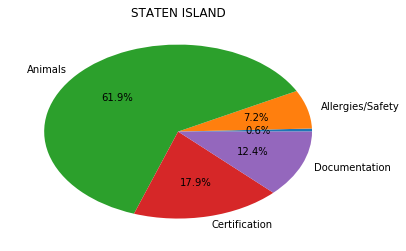

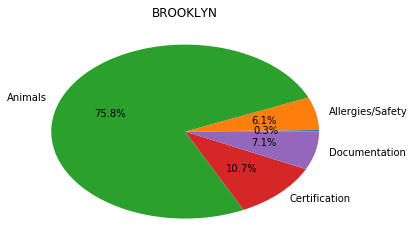

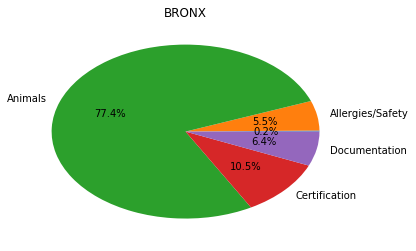

In [80]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

boros_list = df['BORO'].unique()
boros_list = np.delete(boros_list, -1)

for boro in boros_list:
    violations = df[df['BORO'] == boro].groupby(by='VIOLATION TYPE', sort=True)['BORO'].count().head(5)
    violations_pct = violations.values/violations.sum()
    ax = plt.pie(violations, labels=violations.keys(), autopct=lambda pct: func(pct, violations))
    plt.title(boro)
    plt.show()